In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
from torch.nn.functional import pad
import torch.nn.init as init
import copy
from torch import autograd
from torchvision.utils import make_grid
from torchdiffeq import odeint_adjoint as odeint



class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h 
    return h





In [27]:
import functools
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

from torch.optim import Adam,AdamW
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from torch.optim.lr_scheduler import OneCycleLR



f_theta = torch.nn.DataParallel(ScoreNet())
f_theta = f_theta.to(device)

n_epochs =   10#@param {'type':'integer'}
## size of a mini-batch
batch_size =  128 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}
d=28*28*1
tspan=[0,1]
nt=8
h=(tspan[1]-tspan[0])/nt
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optim = Adam(f_theta.parameters(), lr=lr)

# optim=AdamW(f_theta.parameters(),lr=lr)
# scheduler=OneCycleLR(optim,lr,total_steps=n_epochs*len(data_loader),pct_start=0.25,anneal_strategy='cos')


tqdm_epoch = tqdm.trange(n_epochs)


  0%|          | 0/10 [00:21<?, ?it/s]


In [28]:
def log_Gaussian(x,d):
    return -d/2*math.log(2*math.pi)-torch.sum(x**2,dim=1).reshape(-1,1)/2

def grad_log_Gaussian(x):
    return -x



x=torch.randn((1000,784))
print(torch.mean(log_Gaussian(x,d=784)))




tensor(-1112.6425)


In [29]:
def stepRK4(odefun, z, net,t0, t1):
    h = t1 - t0 # step size
    z0 = z
    K = h * odefun(z0, t0, net)
    z_temp = z0 + (1.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp =z_temp+ (2.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp = z_temp+(2.0/6.0) * K
    K = h * odefun( z0 + K , t0+h ,net)
    z_temp = z_temp+(1.0/6.0) * K
    return z_temp



def stepRK1(odefun, z, net,t0, t1):
    z0 = z
    z_temp =z0 + (t1 - t0) * odefun(z0, t0, net)

    return z_temp

def odefun(x, t, net):
    # x=x.reshape(x.shape[0],1,28,28)
    batch_time_step = torch.ones(x.shape[0], device=device) * t
    dx=net(x, batch_time_step)
    return dx


def odefun_backward(cat_var, t, net):
    x=cat_var[:,0:d].reshape(cat_var.shape[0],1,28,28)
    # score=cat_var[:,d+1:-1]

    divergence_f=torch.zeros(x.shape[0],device=device)
    batch_time_step = torch.ones(x.shape[0], device=device) * t
    f=net(x, batch_time_step).reshape(x.shape[0],-1)

    
    #近似计算divergence_f
    v=torch.randn(f.shape).to(device)
    vf=torch.sum(f*v, dim=1)
    
    a=autograd.grad(vf.sum(),x,create_graph=True)[0].reshape(x.shape[0],-1)
    divergence_f=torch.sum(a*v, dim=1)
    d_log=-divergence_f.reshape(-1,1)

    return torch.cat((f,d_log),dim=1)





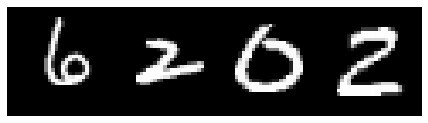

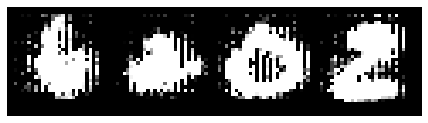

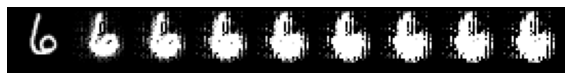

In [30]:
for x, y in data_loader:
    x = x.to(device)
    samples=x[0:4,:,:,:].clamp(0.0, 1.0).cpu().detach()
    sample_grid = make_grid(samples, nrow=4)
    plt.figure(figsize=(8,2))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()


    z_temp,tk=x,0
    for k in range(nt):
        tk=h*k
        z_temp = stepRK4(odefun, z_temp , f_theta, tk, tk+h)

    samples=z_temp[0:4,:,:,:].clamp(0.0, 1.0).cpu().detach()

    sample_grid = make_grid(samples, nrow=4)
    plt.figure(figsize=(8,2))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()

    z_T=x[0,:,:,:].unsqueeze(0)
    z_temp,tk=x[0,:,:,:].unsqueeze(0),0
    for k in range(nt):
        tk=h*k
        z_temp = stepRK4(odefun, z_temp , f_theta, tk, tk+h)
    
        z_T=torch.cat((z_T,z_temp),dim=0)
    samples=z_T.cpu().clamp(0.0, 1.0).detach()

    sample_grid = make_grid(samples,nrow=9)
    plt.figure(figsize=(10,2))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()

    break


In [31]:
from tqdm import tqdm
llh_record=[]
loss_record=[]
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}:")
    with tqdm(data_loader, unit="batch") as tepoch:
        for batch in tepoch:
            x,y=batch
            x = x.to(device)
            
            z_temp,tk=x,0
            for k in range(nt):
                tk=h*k
                z_temp = stepRK4(odefun, z_temp , f_theta, tk, tk+h)

            z_terminal=z_temp
            log_terminal=log_Gaussian(x=z_terminal.reshape(x.shape[0],-1),d=784)
            log_temp=log_terminal
            
            # grad_terminal=grad_log_Gaussian(z_terminal)
            # score_Full=grad_terminal.unsqueeze(4)

            z_back=z_terminal.reshape(x.shape[0],-1)
            cat_var=torch.cat((z_back,log_temp),dim=1)
            

            
            for k in  range(nt):
                tk=1-k*h
                cat_var= stepRK4(odefun_backward, cat_var , f_theta, tk, tk-h)
            

                
            z,log_temp=cat_var[:,0:d],cat_var[:,d]
            optim.zero_grad()

            loss=-torch.mean(log_temp)
            loss.backward()
            optim.step()
            # scheduler.step()

            llh_record.append(-torch.mean(log_temp).detach().cpu())
            tepoch.set_description('Loss: {:5f} '.format(-torch.mean(log_temp).detach().cpu()/math.log(2)/d+8))
            tepoch.set_postfix(loss=loss.item())
    torch.save(f_theta.state_dict(), 'experiment/MNIST.pth')
    if (epoch+1) % 200 == 0:
            for p in optim.param_groups:
                p['lr'] /= 2
            print("lr: ", p['lr'])




        

        

Epoch 1/10:


Loss: 6.399333 :  28%|██▊       | 130/469 [10:25<27:11,  4.81s/batch, loss=-870]   


KeyboardInterrupt: 

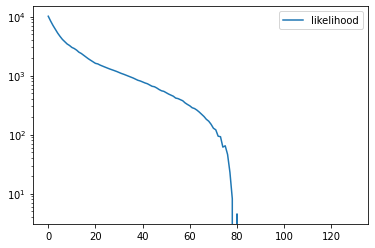

In [32]:
from plot_tools import *

# plot_loss(llh_record)
plot_loss(llh_record)

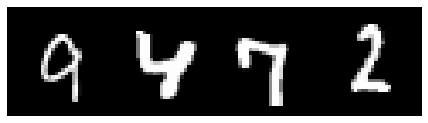

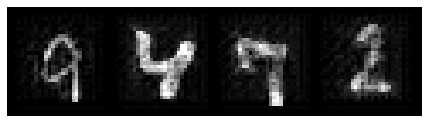

In [33]:
for x, y in data_loader:
    x = x[0:4,:,:,:].to(device)
    samples=x[0:4,:,:,:].clamp(0.0, 1.0).cpu().detach()
    sample_grid = make_grid(samples, nrow=4)
    plt.figure(figsize=(8,2))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()


    z_temp,tk=x,0
    for k in range(nt):
        tk=h*k
        z_temp = stepRK4(odefun, z_temp , f_theta, tk, tk+h)

    z_terminal=z_temp
    log_terminal=log_Gaussian(x=z_terminal.reshape(x.shape[0],-1),d=784)
    log_temp=log_terminal
    z_back=z_terminal.reshape(x.shape[0],-1)
    cat_var=torch.cat((z_back,log_temp),dim=1)
    
    for k in  range(nt):
        tk=1-k*h
        cat_var= stepRK4(odefun_backward, cat_var , f_theta, tk, tk-h)
    z,log_temp=cat_var[:,0:d].reshape(-1,1,28,28),cat_var[:,d]
    samples=z.clamp(0.0, 1.0).cpu().detach()
    sample_grid = make_grid(samples,nrow=4)
    plt.figure(figsize=(8,2))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()

    break

In [ ]:

x=torch.randn(16,1,28,28).to(device)
zFull = torch.zeros(*x.shape , nt+1, device=x.device, dtype=x.dtype) # make tensor of size z.shape[0], z.shape[1], nt

z_temp = x

for k in range(nt):
    tk=1-h*k
    z_temp = stepRK4(odefun, z_temp , f_theta, tk, tk-h)

z_gen=z_temp
samples=z_gen.clamp(0.0, 1.0).cpu().detach()
%matplotlib inline

sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()



# samples=zFull[0:16,:,:,:,-1].clamp(0.0, 1.0).cpu().detach()
# %matplotlib inline

# sample_grid = make_grid(samples, nrow=int(np.sqrt(16)))

# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
# plt.show()